# **Project 4 - Q Learning**

For this project, you will be tasked with both implementing and explaining key components of the Q-learning algorithm.

All the code deliverables has to be provided within this notebook.

# 1 - Packages
Let's first import all the packages that you will need during this assignment.

* 
[numpy](https://numpy.org/) - is the main package for scientific computing with Python
*
[matplotlib](https://matplotlib.org/) - is a plotting library
*
[gym](https://gym.openai.com/docs/) - Gym is a toolkit for developing and comparing reinforcement learning algorithms.
*
[gym.spaces](http://gym.openai.com/docs/) - Every environment comes with an action_space and an observation_space. These attributes are of type Space, and they describe the format of valid actions and observations.
*
[time](https://docs.python.org/3/library/time.html?highlight=time#module-time) - will be used to track how much time each computation takes
*
[copy](https://docs.python.org/3/library/copy.html) - A copy is sometimes needed so one can change one copy without changing the other.
*
[Threading](https://docs.python.org/3/library/threading.html) - This module constructs higher-level threading interfaces on top of the lower level thread module.
*
[Collections](https://docs.python.org/2/library/collections.html) - This module implements specialized container datatypes providing alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple.


In [0]:
#######################################################################
# Authors:
# Nathan Margaglio (nathanmargaglio@gmail.com)                                                          
# Mihir Hemant Chauhan (mihirhem@buffalo.edu)                       
# Qian Cheng (qcheng2@buffalo.edu)                            
#######################################################################
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym.spaces
import time
import copy
import threading
import time
import collections

## Basic Environment
Here we define our grid-world environment. No need to make any changes.

In [0]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ['human'] }
    
    def __init__(self, normalize=False, size=4):
        self.observation_space = gym.spaces.Box(0, size, (size,))
        self.action_space = gym.spaces.Discrete(4)
        self.max_timesteps = size*2 + 1
        self.normalize = normalize
        self.size = size

        # Generate State Transition Table
        self.transition_matrix = []
        for x in range(size + 1):
            state_x = []
            for y in range(size + 1):
                state_y = []
                for a in range(4):
                    one_hot = np.zeros(4)
                    one_hot[a] = 1
                    state_y.append(one_hot)
                state_x.append(state_y)
            self.transition_matrix.append(state_x)
        
    def transition_func(self, x, y, action, return_probs=False):
        probs = self.transition_matrix[x][y][action]
        if return_probs:
            return probs
        else:
            return np.random.choice(len(probs), p=probs)

    def _get_distance(self, x, y):
        return abs(x[0] - y[0]) + abs(x[1] - y[1])
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size, self.size]
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.prev_distance = self._get_distance(self.agent_pos, self.goal_pos)
        return np.array(self.agent_pos)/1.
    
    def step(self, action):
        action_taken = self.transition_func(self.agent_pos[0], self.agent_pos[1], action)
        self.state = np.random.choice(self.observation_space.shape[0])
        if action_taken == 0:
            self.agent_pos[0] += 1
        if action_taken == 1:
            self.agent_pos[0] -= 1
        if action_taken == 2:
            self.agent_pos[1] += 1
        if action_taken == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.size)
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        current_distance = self._get_distance(self.agent_pos, self.goal_pos)
        if current_distance < self.prev_distance:
            reward = 1
        elif current_distance > self.prev_distance:
            reward = -1
        else:
            reward = -1
        self.prev_distance = current_distance
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps or current_distance == 0:
            done = True
        else:
            done = False
        info = {}
        
        obs = self.agent_pos
        if self.normalize:
            obs = obs/self.size
        return obs, reward, done, info
        
    def render(self, mode='human'):
        plt.imshow(self.state)

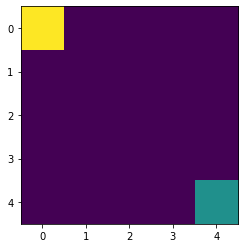

In [3]:
env = GridEnvironment()
obs = env.reset()
env.render()

## Random Agent
This runs the environment with a random agent that just takes random actions. Neither does he learn, nor remember anything. Try to run it!

In [0]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        return np.random.choice(self.action_space.n)
        
    def step(self, observation, verbose=False):
        return self.policy(observation)

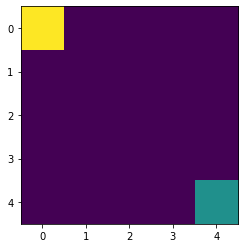

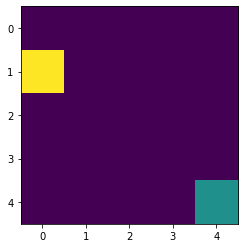

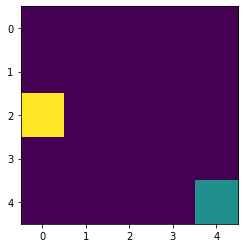

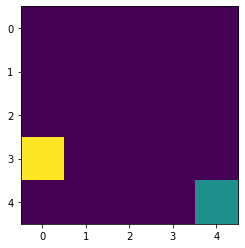

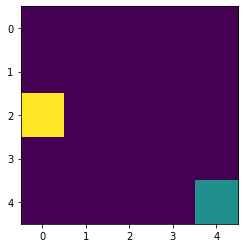

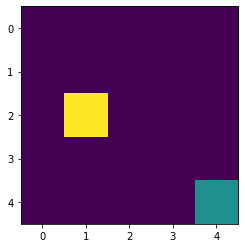

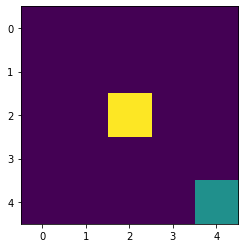

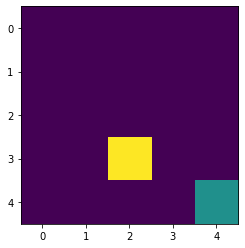

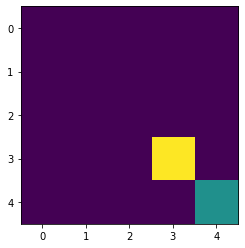

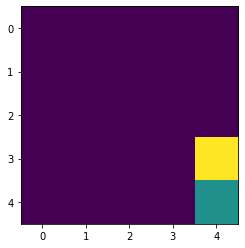

In [7]:
env = GridEnvironment(normalize=True)
agent = RandomAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

## Heuristic Agent
This runs the environment with a heuristic agent. No need to make any changes. Try to run it!

In [0]:
class HeuristicAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        # 0 - down
        # 1 - up
        # 2 - right
        # 3 - left
        if (observation[0] < 1.):
            return 0
        if (observation[1] < 1.):
            return 2
        return 0
        
    def step(self, observation, verbose=False):
        if verbose:
            print(observation)
        return self.policy(observation)

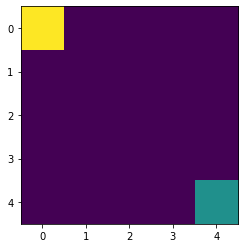

[0. 0.]


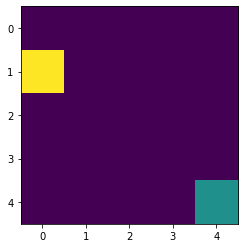

[0.25 0.  ]


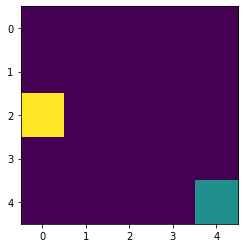

[0.5 0. ]


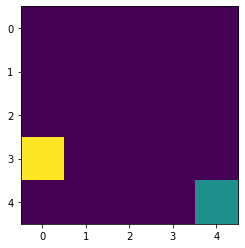

[0.75 0.  ]


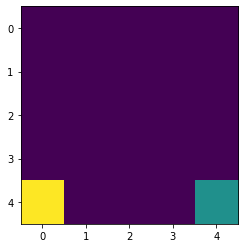

[1. 0.]


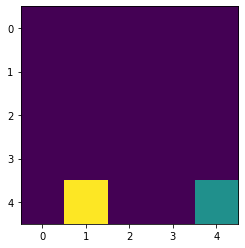

[1.   0.25]


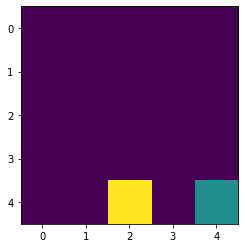

[1.  0.5]


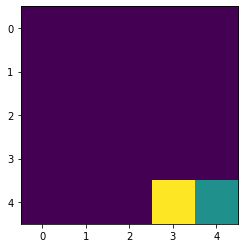

[1.   0.75]


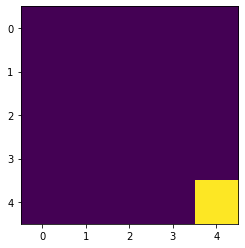

In [9]:
env = GridEnvironment(normalize=True)
agent = HeuristicAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

## Tabular Q-Learning
This is where you need to define policy and update Q tables.
For policy.

*  
[np.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) - Returns the indices of the maximum values along an axis.

### Epsilon

Our agent will randomly select its action at first by a certain percentage, called ‘exploration rate’ or ‘epsilon’. This is because at first, it is better for the agent to try all kinds of things before it starts to see the patterns. When it is not deciding the action randomly, the agent will predict the reward value based on the current state and pick the action that will give the highest reward. We want our agent to decrease the number of random action, as it goes, so we indroduce an exponential-decay epsilon, that eventually will allow our agent to explore the evironment. \\



###  <font color='red'>Task 1: Implement policy function.</font>  <br>
**Instructions:**
- Our agent will randomly select its action at first by a certain percentage, called ‘exploration rate’ or ‘epsilon’. This is because at first, it is better for the agent to try all kinds of things before it starts to see the patterns. Select a random uniform number. If it's less than epsilon, return the random choice action space.
- When it is not deciding the action randomly, the agent will predict the reward value based on the current state and pick the action that will give the highest reward. 
\begin{align} \notag
\pi\left(s_{t}\right)=\underset{a \in A}{\operatorname{argmax}} Q_{\theta}\left(s_{t}, a\right)
\end{align} 
- Return the policy
- Please note, that the name for all the variables should start with <mark>self</mark>, thus </br> 

epsilon $\rightarrow$ self.epsilon </br> 
action_space $\rightarrow$ self.action_space

###  <font color='red'>Task 2: Update Q-table</font>  <br>
**Instructions:**
            \begin{align} \notag
            Q^{n e w}\left(s_{t}, a_{t}\right) \leftarrow(1-\alpha) \cdot \underbrace{Q\left(s_{t}, a_{t}\right)}_{\text {old value }}+\underbrace{\alpha}_{\text {learning rate }} \cdot \overbrace{(\underbrace{r_{t}}_{\text {reward }} + \underbrace{\gamma}_{\text {discount factor }} \underbrace{\max _{a} Q\left(s_{t+1}, a\right)}_{a})}^{\text {learned value }}
            \end{align} 

In [0]:
def console_log(text, value, priority):
  if LOG_LEVEL >= priority:
    if value is not None:
      print(text, value)
    else:
      print(text)

class QLearningAgent:
    def __init__(self, env, epsilon=1.0, lr=0.1, gamma=0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        q_table_dim = env.observation_space.shape[0] + 1
        self.q_table = np.zeros((q_table_dim, q_table_dim, env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

    def policy(self, observation):
      # Code for policy (Task 1) (30 points)
      rand_num = np.random.uniform()
      observation = observation.astype(int)
      
      # console_log("\tobservation: ", observation, 1)
      console_log("\tepsilon: ", self.epsilon, 2)
      console_log("\trand: ", rand_num, 2)
      
      if rand_num < self.epsilon:
        console_log("\tRandom Step", None, 1)
        best_action = np.random.choice(self.action_space.n)
      else:
        console_log("\tLearned Step", None, 1)
        curr_row = observation[0]
        curr_col = observation[1]                             
        possible_actions = self.q_table[curr_row, curr_col]
        best_action = np.argmax(possible_actions)
      return best_action
        
    def step(self, observation):
      return self.policy(observation)
    
    def update(self, state, action, reward, next_state):
        # Code for updating Q Table (Task 2) (20 points)
        # Get the current row/col and next row/col
        state = state.astype(int) # current location
        curr_row = state[0]
        curr_col = state[1]
        next_state = next_state.astype(int) # next location
        next_row = next_state[0]
        next_col = next_state[1]

        console_log("\tstate: ", state, 1)
        console_log("\taction: ", action_map[action], 1)
        console_log("\treward: ", reward, 1)
        console_log("\tnext_state", next_state, 1)   
        console_log("", None, 1)

        # Update the Q-table to incentivize postive rewards and decentavize negative rewards
        # Learned value = the reward scaled by the probability of occurance, gamma 
        learned_val = reward + self.gamma * np.max(self.q_table[next_row, next_col])
        new_val = (1-self.gamma)*self.q_table[curr_row,curr_col,action] + self.lr*learned_val
        self.q_table[curr_row,curr_col,action] = new_val

        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

### Training
### Environment
First, we initialize our environment.  The environment, loosely structured like [OpenAI's Gym Environments](https://gym.openai.com/), has three main methods: `reset`, `step` and `render`. You'll only need `reset` and `step` here.

- When we call **reset**, we initialize the environment with a fresh episode. This allows us to effectively run through episodes (only needing to call reset at the beginning of an episode), but, more importantly, `reset()` returns the environment's initial state.

- The **step** method accepts an action as a parameter (which, for this example, is an integer in [0, 3]), processes the action, and returns the new state, the reward for performing the action, and a boolean indicating if the run is over.

### Agent
When we initialize the agent, we must pass both a `environment` into QLearningAgent function.
###  <font color='red'>Task 3: Implement the training algorithm</font>  <br>
**Instructions:**
- After initialization, pass the initial state to obs. Then check if it's already done. If done = False, you'll keep going. While it's not done, you'll need to update `state`, `action`,`reward` and `next_state`. You can get action by `step` the current state on agent. Use `copy` to record the current state. `step` the current action on environment to return the new state, the reward for performing the action, a boolean indicating if the run is over and some other information. Add the new reward on the total rewards. Use `copy` to save the new state returned by `step`. Update the `state`, `action`, `reward`, `next_state` of agent.

In [0]:
env = GridEnvironment() # note: we do not normalize
agent = QLearningAgent(env)
episodes = 1000 # number of games we want the agent to play
delta_epsilon = agent.epsilon/episodes

total_rewards = []
epsilons = [agent.epsilon]
action_map = ["down", "up", "right", "left"]
action_map_abbrv = ["D", "U", "R", "L"]

# LOG_LEVEL controls what logging messages are printed
# 0 - None
# 1 - state, reward, action, next state
# 2 - epsilon and rand_num values
LOG_LEVEL = 0

# Training Process (Task 3) (20 points)
for t in range(0, episodes):
  console_log("t: ", t, 1)
  obs = env.reset()
  done = False
  while not done:
    state = copy.copy(obs)
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    agent.update(state, action, reward, obs)
    total_rewards.append(reward)
  new_epsilon = epsilons[0] * np.exp(-delta_epsilon * t)
  # new_epsilon = agent.epsilon - delta_epsilon
  epsilons.append(new_epsilon)
  agent.set_epsilon(new_epsilon)


#### Visualize $\epsilon$
Plot our value of $\epsilon$ over each episode

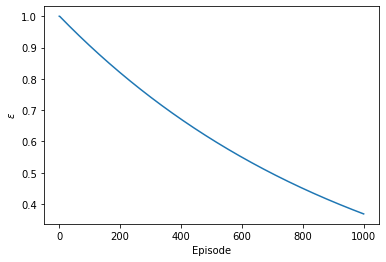

In [175]:
plt.xlabel('Episode')
plt.ylabel('$\epsilon$')
plt.plot(epsilons)

#### Visualize Rewards
Plot total_rewards per episode.  We apply a rolling mean of window $10$ to visualize easier.

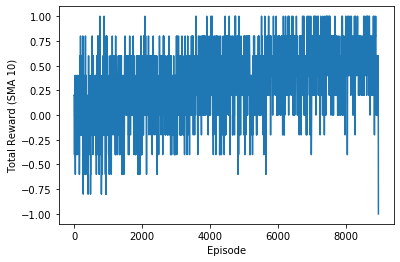

In [176]:
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])

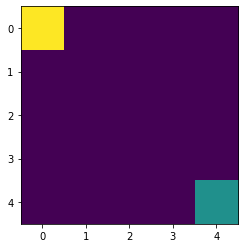

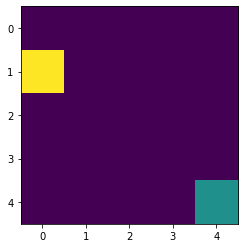

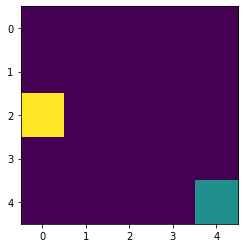

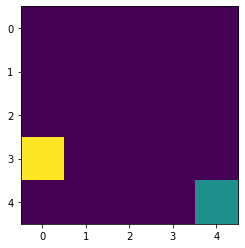

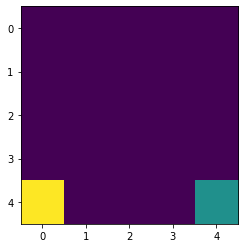

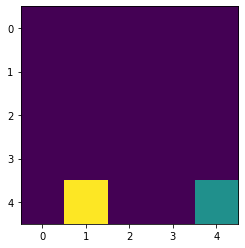

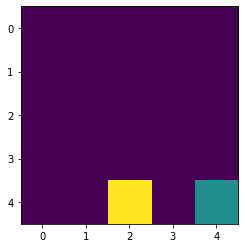

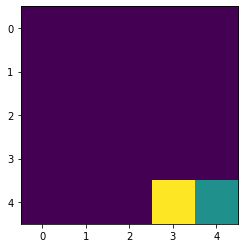

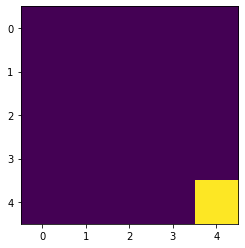

                  Action Probabilities
| row | col |  down   |   up    |  right  |  left   |
|-----|-----|---------|---------|---------|---------|
|  0  |  0  | +0.1235 | -0.0988 | +0.1235 | -0.0988 |
|  0  |  1  | +0.1235 | -0.0988 | +0.1235 | -0.0988 |
|  0  |  2  | +0.1235 | -0.0988 | +0.1235 | -0.0988 |
|  0  |  3  | +0.1235 | -0.0988 | +0.1235 | -0.0988 |
|  0  |  4  | +0.1234 | -0.0988 | -0.0988 | -0.0988 |
|  1  |  0  | +0.1235 | -0.0988 | +0.1235 | -0.0988 |
|  1  |  1  | +0.1235 | -0.0988 | +0.1235 | -0.0988 |
|  1  |  2  | +0.1235 | -0.0988 | +0.1235 | -0.0988 |
|  1  |  3  | +0.1234 | -0.0988 | +0.1234 | -0.0988 |
|  1  |  4  | +0.1233 | -0.0988 | -0.0988 | -0.0988 |
|  2  |  0  | +0.1235 | -0.0988 | +0.1235 | -0.0988 |
|  2  |  1  | +0.1235 | -0.0988 | +0.1235 | -0.0988 |
|  2  |  2  | +0.1234 | -0.0988 | +0.1234 | -0.0988 |
|  2  |  3  | +0.1233 | -0.0988 | +0.1233 | -0.0988 |
|  2  |  4  | +0.1222 | -0.0987 | -0.0989 | -0.0988 |
|  3  |  0  | +0.1235 | -0.0988 | +0.1235 |

In [179]:
def print_table(table):
  print("| row | col |  down   |   up    |  right  |  left   |")
  print("|-----|-----|---------|---------|---------|---------|")
  for i in range(0, table.shape[0]):
    for j in range(0, table.shape[1]):
      print("|  %1d  |  %1d  |" % (i, j), end='')
      for k in range(0, table.shape[2]):
        print(" %+5.4f |"% (table[i, j, k]), end='')
      print()

def print_state_transitions(table):
  # Print header row
  print("|   |", end="")
  for i in range(0, table.shape[0]):
    print(" %1d |" % (i), end="")
  print()

  # Fill in rows
  for i in range(0, table.shape[0]):
    print("| %1d |" % (i), end="")
    for j in range(0, table.shape[1]):
      action = np.argmax(table[i, j])
      direction = action_map_abbrv[action]
      print(" %c |" % (direction), end="")
    print()


env = GridEnvironment()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

print("                  Action Probabilities")
print_table(agent.q_table)
print("\n     Actions by State")
print_state_transitions(agent.q_table)